In [1]:
# Video Lesson 4: Part 2 (about mid-way)
# continue image prediction two ways: 'from scratch' and 'from 4 lines'
# try to meet at middle; also learn variations of what pyTorch & fastai offer

# Learnt in Part 1 of this lesson:
'''data loader
metric
mini batch
sgd
single layer (linear)
three layers (2 hidden + activation); appears final activation layer (MSE, sigmoid, ...) not included in count'''

'data loader\nmetric\nmini batch\nsgd\nsingle layer (linear)\nthree layers (2 hidden + activation); appears final activation layer (MSE, sigmoid, ...) not included in count'

In [2]:
!pip install -Uqq fastbook
from fastbook import *
from fastai.vision.all import *

In [3]:
setup_book()

In [4]:
pets = untar_data(URLs.PETS)
print(pets.ls())
Path.BASE_PATH = pets
print(pets.ls())

[Path('/root/.fastai/data/oxford-iiit-pet/images'), Path('/root/.fastai/data/oxford-iiit-pet/annotations')]
[Path('images'), Path('annotations')]


In [5]:
Path(pets/'images').ls(), Path(pets/'annotations').ls()

((#7393) [Path('images/boxer_135.jpg'),Path('images/Persian_133.jpg'),Path('images/english_cocker_spaniel_182.jpg'),Path('images/Siamese_225.jpg'),Path('images/pug_78.jpg'),Path('images/staffordshire_bull_terrier_97.jpg'),Path('images/staffordshire_bull_terrier_24.jpg'),Path('images/wheaten_terrier_143.jpg'),Path('images/Sphynx_78.jpg'),Path('images/staffordshire_bull_terrier_198.jpg')...],
 (#7) [Path('annotations/._trimaps'),Path('annotations/trainval.txt'),Path('annotations/list.txt'),Path('annotations/test.txt'),Path('annotations/xmls'),Path('annotations/README'),Path('annotations/trimaps')])

In [6]:
!ls -l {pets/'annotations'}

total 1108
-rw-r--r-- 1 1000 1000 172300 Jun 29  2012 list.txt
-rw-r--r-- 1 1000 1000   1476 Jun 30  2012 README
-rw-r--r-- 1 1000 1000  84319 Jun 29  2012 test.txt
-rw-r--r-- 1 1000 1000  87776 Jun 29  2012 trainval.txt
drwxr-xr-x 2 1000 1000 618496 Oct  8  2018 trimaps
drwxr-xr-x 2 1000 1000 159744 Jun 29  2012 xmls


In [7]:
!cat {pets/'annotations/README'}

OXFORD-IIIT PET Dataset
-----------------------
Omkar M Parkhi, Andrea Vedaldi, Andrew Zisserman and C. V. Jawahar

We have created a 37 category pet dataset with roughly 200 images for each class. 
The images have a large variations in scale, pose and lighting. All images have an 
associated ground truth annotation of breed, head ROI, and pixel
level trimap segmentation.

Contents:
--------
trimaps/ 	Trimap annotations for every image in the dataset
		Pixel Annotations: 1: Foreground 2:Background 3: Not classified
xmls/		Head bounding box annotations in PASCAL VOC Format

list.txt	Combined list of all images in the dataset
		Each entry in the file is of following nature:
		Image CLASS-ID SPECIES BREED ID
		ID: 1:37 Class ids
		SPECIES: 1:Cat 2:Dog
		BREED ID: 1-25:Cat 1:12:Dog
		All images with 1st letter as captial are cat images while
		images with small first letter are dog images.
trainval.txt	Files describing splits used in the paper.However,
test.txt	you are encouraged to try ra

In [8]:
!head {pets/'annotations/list.txt'}

#Image CLASS-ID SPECIES BREED ID
#ID: 1:37 Class ids
#SPECIES: 1:Cat 2:Dog
#BREED ID: 1-25:Cat 1:12:Dog
#All images with 1st letter as captial are cat images
#images with small first letter are dog images
Abyssinian_100 1 1 1
Abyssinian_101 1 1 1
Abyssinian_102 1 1 1
Abyssinian_103 1 1 1


In [9]:
image_paths = Path(pets/'images').ls().sorted()
image_paths[:3]

(#3) [Path('images/Abyssinian_1.jpg'),Path('images/Abyssinian_10.jpg'),Path('images/Abyssinian_100.jpg')]

In [10]:
# 37 * 200 images.  Rather than use regular expressions on filename, we can use this lookup table for labels
# this particular exercise looks at cats and dogs the same way - only breed (with 37 levels) matters
# so can just match on first column (root of name without .jpg), then use the second column as the label
labels = pd.read_csv(pets/'annotations/list.txt', sep=' ',
                     skiprows=6, header=None,
                     names=['image', 'ClassID', 'species', 'breed'])
labels

,image,ClassID,species,breed
0,Abyssinian_100,1,1,1
1,Abyssinian_101,1,1,1
2,Abyssinian_102,1,1,1
3,Abyssinian_103,1,1,1
4,Abyssinian_104,1,1,1
...,...,...,...,...
7344,yorkshire_terrier_96,37,2,25
7345,yorkshire_terrier_97,37,2,25
7346,yorkshire_terrier_98,37,2,25
7347,yorkshire_terrier_99,37,2,25


In [11]:
# expect 37*200; 51 rows are missing
labels.ClassID.value_counts().sort_index() # sort_values() would have sorted by the 2nd column

1     198
2     200
3     200
4     200
5     200
6     200
7     200
8     184
9     199
10    200
11    200
12    190
13    196
14    200
15    200
16    200
17    200
18    200
19    199
20    200
21    200
22    200
23    196
24    200
25    200
26    200
27    200
28    200
29    200
30    200
31    199
32    200
33    199
34    200
35    189
36    200
37    200
Name: ClassID, dtype: int64

In [12]:
str(image_paths[0]), image_paths[0].name

('/root/.fastai/data/oxford-iiit-pet/images/Abyssinian_1.jpg',
 'Abyssinian_1.jpg')

In [13]:
# using regular expressions for now
re.findall(pattern=r'(.+)_\d+\.jpg', string=image_paths[-1].name)

['yorkshire_terrier']

In [14]:
# DataBlock is a template to create a DataLoader
# We start with our own data, use DataBlock API to specify the components, then use it to build the DataLoader

# DataLoader is a class that provides mini-batches of a pre-defined number of items from a dataset formed by using a DataBlock
# when we have two separate DataLoaders, it is sometimes easier to combine into one construct called DataLoaders
# fastai knows which DataLoader should be used for any given operation

pets_dblk = DataBlock(blocks=(ImageBlock, CategoryBlock),
                    get_items=get_image_files,
                    splitter=RandomSplitter(valid_pct=0.2, seed=1),
                    get_y=using_attr(RegexLabeller(r'(.+)_\d+\.jpg'), 'name'),
                    item_tfms=Resize(460),
                    batch_tfms=aug_transforms(size=224, min_scale=0.75))
dls = pets_dblk.dataloaders(pets/'images')

In [15]:
# 1. resize to a 'large' image - larger than what we expect to see in data
# 2. make augmentation functions composable, so can be done on GPU together

# on training, crop area is chosen randomly; on valid, crop area is on center

# Checking and debugging a data block

In [16]:
pets_dblk.summary(source=pets/'images', show_image_batch=True, bs=4)

Setting-up type transforms pipelines
Found 7390 items
2 datasets of sizes 5912,1478
Setting up Pipeline: PILBase.create
Setting up Pipeline: partial -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}

Building one sample
  Pipeline: PILBase.create
    starting from
      /root/.fastai/data/oxford-iiit-pet/images/Russian_Blue_59.jpg
    applying PILBase.create gives
      PILImage mode=RGB size=500x333
  Pipeline: partial -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
    starting from
      /root/.fastai/data/oxford-iiit-pet/images/Russian_Blue_59.jpg
    applying partial gives
      Russian_Blue
    applying Categorize -- {'vocab': None, 'sort': True, 'add_na': False} gives
      TensorCategory(9)

Final sample: (PILImage mode=RGB size=500x333, TensorCategory(9))


Found 7390 items
2 datasets of sizes 5912,1478
Setting up Pipeline: PILBase.create
Setting up Pipeline: partial -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
Setting up after_

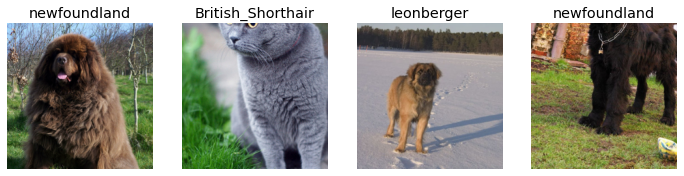

In [17]:
# one_batch = first(dls)
# show_image_batch(one_batch)
# took too long

dls.show_batch(nrows=1, ncols=4)

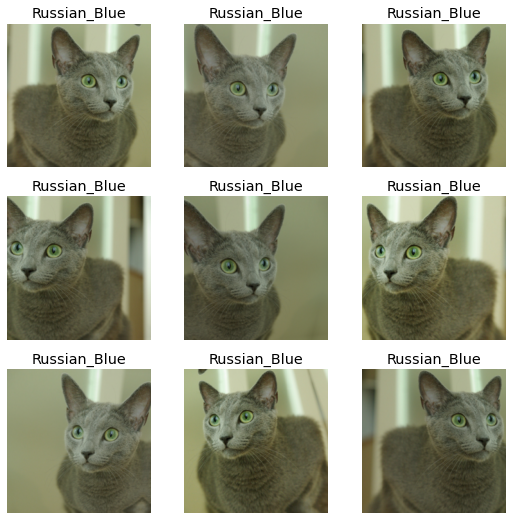

In [18]:
dls.show_batch(max_n=9, show=True, unique=True) # unique=T shows augmentations of same image

In [19]:
learn01 = cnn_learner(dls=dls, arch=resnet152, metrics=error_rate)
learn01.fine_tune(2)

Downloading: "https://download.pytorch.org/models/resnet152-b121ed2d.pth" to /root/.cache/torch/hub/checkpoints/resnet152-b121ed2d.pth


epoch,train_loss,valid_loss,error_rate,time
0,0.917190,0.274371,0.081191,02:33


epoch,train_loss,valid_loss,error_rate,time
0,0.412550,0.313007,0.085250,03:26
1,0.246998,0.200047,0.059540,03:26


In [20]:
learn01.loss_func

FlattenedLoss of CrossEntropyLoss()

# Understanding cross-entropy loss

In [21]:
x,y = dls.one_batch()
x.shape, y.shape

((64, 3, 224, 224), (64,))

In [22]:
y

TensorCategory([11,  0, 36, 25, 15,  0, 24, 24, 25,  4,  0, 36, 12, 14,  8, 33, 25, 19, 26, 20, 31,  9, 15, 28, 34, 27, 14, 11, 19, 21,  6, 19, 34, 26, 35, 12, 26, 13, 28, 22, 25,  8, 26,  3, 15,  8,  9,  1,
        15,  8, 33,  5,  7, 31, 32, 36, 12,  1, 12, 10,  9, 28, 13, 19], device='cuda:0')

In [23]:
dls.vocab

['Abyssinian', 'Bengal', 'Birman', 'Bombay', 'British_Shorthair', 'Egyptian_Mau', 'Maine_Coon', 'Persian', 'Ragdoll', 'Russian_Blue', 'Siamese', 'Sphynx', 'american_bulldog', 'american_pit_bull_terrier', 'basset_hound', 'beagle', 'boxer', 'chihuahua', 'english_cocker_spaniel', 'english_setter', 'german_shorthaired', 'great_pyrenees', 'havanese', 'japanese_chin', 'keeshond', 'leonberger', 'miniature_pinscher', 'newfoundland', 'pomeranian', 'pug', 'saint_bernard', 'samoyed', 'scottish_terrier', 'shiba_inu', 'staffordshire_bull_terrier', 'wheaten_terrier', 'yorkshire_terrier']

In [24]:
# log_softmax, followed by nll_loss == nn.CrossEntropyLoss

In [27]:
interp = ClassificationInterpretation.from_learner(learn01)

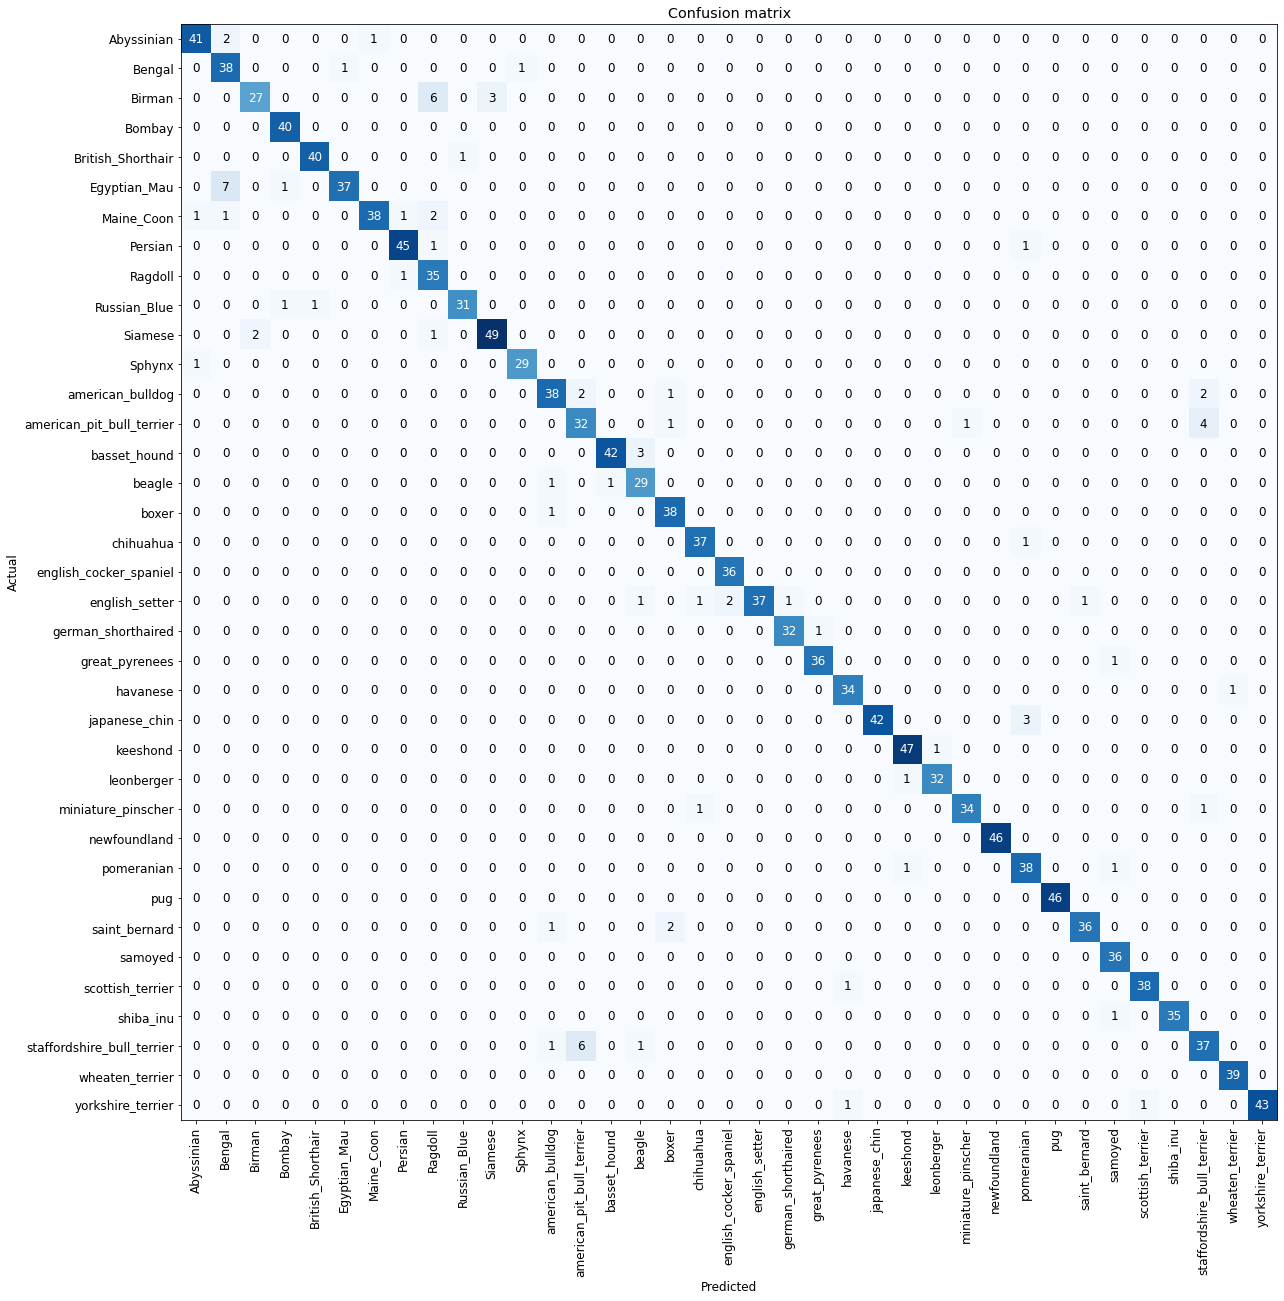

In [28]:
interp.plot_confusion_matrix(figsize=(18,18))

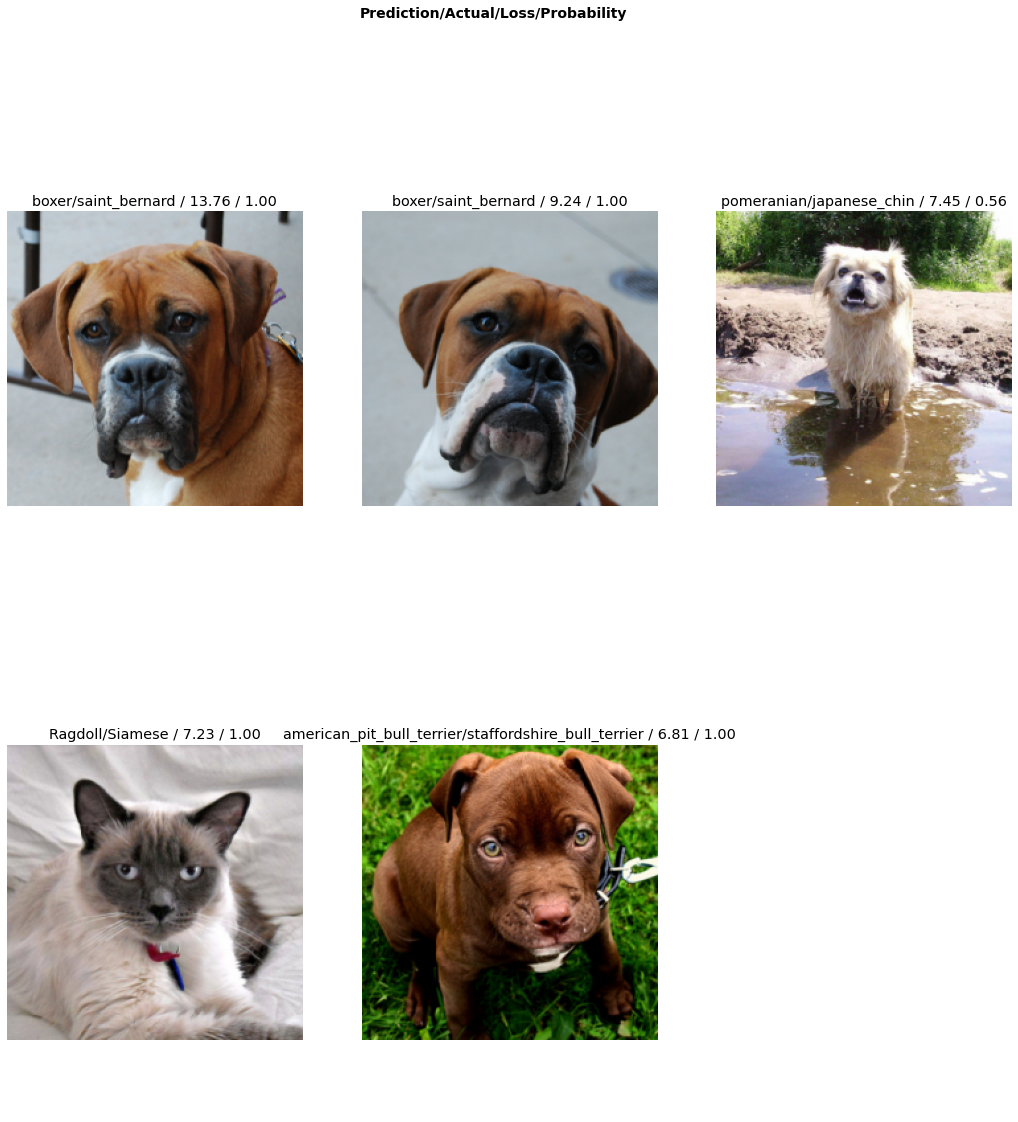

In [29]:
interp.plot_top_losses(5, largest=True, figsize=(18,18))

In [31]:
interp.most_confused(min_val=5) # compare with human evaluators (expert or usual-and-customary?)

[('Egyptian_Mau', 'Bengal', 7),
 ('Birman', 'Ragdoll', 6),
 ('staffordshire_bull_terrier', 'american_pit_bull_terrier', 6)]

In [19]:
!nvidia-smi

Mon Feb  1 02:07:31 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   61C    P0    29W /  70W |   1605MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [41]:
torch.cuda.empty_cache()

In [20]:
# check to see if improved when using resnet101
learn02 = cnn_learner(dls=dls, arch=resnet50, metrics=error_rate) # did not like parm: loss_func=nn.CrossEntropyLoss)
learn02.fine_tune(2)
interp = ClassificationInterpretation.from_learner(learn02)
interp.most_confused(min_val=3)

epoch,train_loss,valid_loss,error_rate,time
0,0.969779,0.329148,0.096752,01:16


epoch,train_loss,valid_loss,error_rate,time
0,0.459267,0.316802,0.094046,01:35
1,0.284200,0.233850,0.077131,01:34


[('american_pit_bull_terrier', 'staffordshire_bull_terrier', 6),
 ('staffordshire_bull_terrier', 'american_pit_bull_terrier', 6),
 ('Birman', 'Ragdoll', 5),
 ('Egyptian_Mau', 'Bengal', 5),
 ('Maine_Coon', 'Persian', 4),
 ('Birman', 'Siamese', 3),
 ('British_Shorthair', 'Russian_Blue', 3),
 ('Siamese', 'Birman', 3),
 ('american_bulldog', 'staffordshire_bull_terrier', 3),
 ('basset_hound', 'beagle', 3),
 ('japanese_chin', 'pomeranian', 3),
 ('miniature_pinscher', 'chihuahua', 3),
 ('pomeranian', 'samoyed', 3)]

# Learning Rate Finder

In [ ]:
# plot lr vs loss. (a) take lr corresponding to minimum loss and divide by 10; or (b) take lr before loss stops decreasing

In [22]:
# first set up learner, (DO NOT RUN FIT or FINE_TUNE yet), then invoke lr_finder
learn03 = cnn_learner(dls=dls, arch=resnet34, metrics=error_rate)

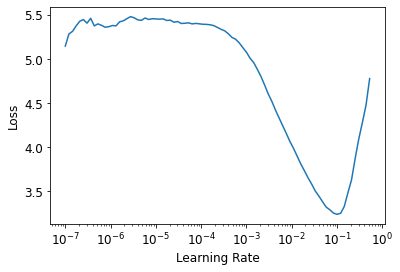

In [23]:
lr_min, lr_steep = learn03.lr_find()

In [30]:
print(f'Minimum/10:{lr_min}, Steepest:{lr_steep}, Mean:{(lr_min+lr_steep)/2.:.2e}')

Minimum/10:0.010000000149011612, Steepest:0.002511886414140463, Mean:6.26e-03


In [31]:
learn03.fine_tune(2, base_lr=6e-3)
# is learnt only using one mini-batch at beginning of training
# not guaranteed to be 'effective' after several epochs or in all mini-batches
# superceded by concept of Momentusm

epoch,train_loss,valid_loss,error_rate,time
0,1.126013,0.394458,0.126522,01:07


epoch,train_loss,valid_loss,error_rate,time
0,0.726623,0.450274,0.127876,01:11
1,0.398087,0.259474,0.075778,01:11


In [ ]:
# YET: it is a very low cost tweak to apply early on and helps get better results most of the time far more quickly while using neglible resources.

# What does fine_tune do?  What is transfer learning?

In [32]:
# 2 ideas:
'''1. after a round of training over multiple epochs, parameters are no longer random, instead represent 'best estimates';
    so, why throw them away and start over when encountering a new dataset in same domain?
2. in a neural network, early layers learn general features (e.g. edges, lines, etc.),
    while layers towards the end act like the more discerning judges about the specific examples they see.

Intution behind transfer learning:
1. take the state of the model (architecture plus parameters) after training on a massive dataset in same domain,
    freeze everything but last (few) layers, replace parameters of these last layers with random numbers (i.e. do not change parameters during back propagation in these layers)
    and train on the new (presumably smaller) data.
2. then take this new set of parameters and apply to a totally open (no layers frozen any more) network and re-train
    (fine tune) for a few epochs.
It is expected that the model is now aware of the new data and has applied its earlier learning to the new data in
    an accumulative fashion, such that the results are better than predicting using the generalized model directly
    or a new model trainined only on the new data.'''

"1. after a round of training over multiple epochs, parameters are no longer random, instead represent 'best estimates';\n    so, why throw them away and start over when encountering a new dataset in same domain?\n2. in a neural network, early layers learn general features (e.g. edges, lines, etc.),\n    while layers towards the end act like the more discerning judges about the specific examples they see.\n\nIntution behind transfer learning:\n1. take the state of the model (architecture plus parameters) after training on a massive dataset in same domain,\n    freeze everything but last (few) layers (i.e. do not change parameters during back propagation in these layers)\n    and train on the new (presumably smaller) data.\n2. then take this new set of parameters and apply to a totally open (no layers frozen any more) network and re-train\n    (fine tune) for a few epochs.\nIt is expected that the model is now aware of the new data and has applied its earlier learning to the new data in

In [37]:
# Howard suggest adding a 3rd step. Find epoch where metric is best (then starts degrading)
# Re-train for this number of epochs.  Then re-train from scratch (with what?)

In [38]:
# lr finder plots against loss.  What we really should be doing is finding minima, steepest slope, etc. based on metric

In [39]:
# How do you know you can do better?  You can always do better.  Question is it good enough?